# Disruption problem


## Introduction :


##### **Contexte**


Notre objectif avec ce projet est d'appliquer la théorie des processus de Poisson pour résoudre un **problème de perturbation**, c'est-à-dire, étant donné une trajectoire unique d'un processus ponctuel $N$ agissant comme un processus de Poisson dont l'intensité change soudainement, nous voulons trouver le moment $\tau$ dans le temps où ce changement se produit. Voici ce que nous savons :
  - Nous avons un processus ponctuel $N$, agissant comme un processus de Poisson avec une intensité $a$ qui passe à $b$ à un certain moment $\tau$. Autrement dit, $N(t) = N_a(t) + (N_b(t) - N_a(t))  1_{t > \tau}$
  - $\tau$ suit une distribution exponentielle avec le paramètre $\sigma$
- Nous notons $\mathcal F_t=\sigma(N(s),\ s\le t)$ le champ $\sigma$ contenant l'information donnée par la trajectoire jusqu'au temps $t$.
- Nous notons également $\hat Z(t)=\mathbf P(\tau\le t | \mathcal F_t)$ la probabilité d'avoir passé $\tau$ au temps $t$, étant donné l'état actuel des observations


##### **Le résultat clé**

Nous avons montré en classe que l'estimateur $\hat Z$ vérifie l'équation différentielle suivante :
$\begin{equation}
   \widehat{Z}(t)=\int_{0}^{t}h(s)(1-\hat{Z}(s))\ d s
   +\int_{0}^{t }
   \frac{(b-a)\widehat{Z}(s^{-})(1-\widehat{Z}(s^{-}))}{\hat\lambda(s)}\Bigl(
   \ d N(s) -\hat\lambda(s) \ d s \Bigr)
 \end{equation}$

 Avec $h(s) = \frac{f(s)}{1 - F(s)} = \sigma$

et $\hat{\lambda}(t) = a + (b - a) \hat{Z}(t)$

##### **Notre approche**

L'équation différentielle ci-dessus décrit la dynamique de $\hat Z$ et comment elle est liée aux sauts de $N$. En comprenant la dynamique de $\hat Z$, nous pouvons comprendre comment simuler l'ensemble du processus. Nous pouvons alors utiliser des méthodes numériques pour résoudre l'équation différentielle, ce qui nous permettra de déterminer $\tau$, selon un critère que nous discuterons plus tard dans le projet.


##### **Motivations, intérêt**


L'intérêt principal de la résolution du problème de perturbation avec le conditionnement de $\mathcal F_t$ est de détecter la perturbation dès qu'elle se produit, afin de pouvoir s'adapter au nouveau processus (dans le cas de la modélisation pour l'analyse du trafic par exemple). En particulier, nous ne pouvons pas avoir accès à la trajectoire complète du processus $N$ pour détecter $\tau$. Il en résulte un compromis entre la possibilité de détecter $\tau$ le plus tôt possible et une précision temporelle suffisante sur $\tau$.



L'équation plus haut peut être réécrite sous la forme :

$\hat{Z}(t) = \int_0^t h(s) (1 - \hat{Z}(s))ds - \int_0^t (b-a) \hat{Z}(s) (1 - \hat{Z}(s))ds + \sum_{T_k \leq t}
\frac{(b-a) \hat{Z}(T_{k}^{-})(1 - \hat{Z}(T_k^-))}{a + (b - a) \hat{Z}(T_k^-)}$

ou les $T_k$ sont les instants de saut de $N$. On en déduit que les sauts de $\hat{Z}$ sont les sauts de N.

Entre deux sauts de N, la dynamique est donnée par :      

$\forall t \in ]T_{n}, T_{n-1}[, \hat{Z(t)} -\hat{Z(T_{n-1})} = \int_{T_{n-1}}^t (h(s) - (b - a) \hat{Z}(s))ds$

Et la taille des sauts est donnée par :

$\hat{Z}(T_n) - \hat{Z}(T_n^-) = \frac{(b - a) \hat{Z}(T_n^-) (1 - \hat{Z}(T_n^-))}{a - (b - a) \hat{Z}(T_n^-)}$

In [ ]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import math

In [ ]:
def sauts(a, b, sigma, t_max):
  """
  Simule une liste d'instant de sauts suivant une loi Na puis Nb

  Arguments :
    a (float) : intensité du premier processus (N_a)
    b (float) : intensité du second processus (N_b)
    sigma (float) : paramètre de la loi de tau
    t_max (float) : instant maximal considéré pour la simulation

  Retours :
    sauts_N[1:] (list[float]) : liste de instant de sauts dans l'ordre croissant
    tau (float) : instant auquel on passe du processus Na au processus Nb

  """

  # on commence par générer tau suivant une loi exp de paramètre sigma.
  tau = np.random.exponential(1/sigma)

  # la liste sauts_N contient les instants de sauts du processus N, la liste sauts_N2 contient les instants de sauts du processus N2
  sauts_N = [0]
  sauts_N2 = [0]

  nv_saut = np.random.exponential(1/a)
  while sauts_N[-1] + nv_saut < tau: # lorsque tau est dépassé, on n'observe plus N1
    sauts_N.append(nv_saut + sauts_N[-1])
    nv_saut = np.random.exponential(1/a)

  nv_saut = np.random.exponential(1/b)
  while sauts_N2[-1] + nv_saut < t_max: # on génère N2 dont on ajoute les instants de sauts à N si ils sont après tau
    sauts_N2.append(nv_saut + sauts_N2[-1])
    nv_saut = np.random.exponential(1/b)
    if sauts_N2[-1] > tau:
      sauts_N.append(sauts_N2[-1])

  return sauts_N[1:], tau # on supprime le 0 du début (qui n'est pas un saut mais était la pour faciliter le code)

In [ ]:
def plot_traj(sauts_l, tau, t_max, n = 10):
  """
  La fonction plot_traj permet de visualiser une trajectoire du processus N comme décrit dans l'énoncé

  Arguments :
    sauts_l (list[float]) : liste d'instants de sauts du processus N
    tau (float) : instant à partir duquel on observe Nb
    t_max (float) : instant de fin de simulation
    n (int) : nombre de points considéré par unité de temps (permet de gérer la définition du graphe)

  Retours : Aucun

  """


  def N(t):
    """
    fonction auxiliaire qui retourne le nombre de sauts avant l'instant t (donc N(t))

    Arguments :
      t (float) : instant considéré

    Retours:
      _ (int) : N(t)
    """
    return sum([1 if (sauts_l[i] < t) else 0 for i in range(0, len(sauts_l))])


  fig, ax = plt.subplots(1, 2, figsize=(12, 4))
  ax[0].eventplot(sauts_l, orientation="horizontal", lineoffsets=[0], linewidth=0.5, label = 'instants de sauts')

  ax[1].plot([t/n for t in range(0, t_max * n)], [N(t/n) for t in range(0, t_max * n)], label = "N(t)")
  if tau < t_max:
     ax[1].axvline(x=tau, color = 'red', linestyle='--', label = "tau")
     ax[0].axvline(x=tau, color = 'red', linestyle='--', label = "tau")

  ax[0].set_title("Instants de sauts")
  ax[0].set_xlabel("t")

  ax[1].set_title("N(t)")
  ax[1].set_xlabel("t")
  ax[1].set_ylabel("N(t)")

  ax[0].legend()
  ax[1].legend()
  plt.grid()
  plt.show()

Valeur de tau pour cette trajectoire : 124.6033474747013
Valeur de a : 1
Valeur de b : 0.125
Valeur de sigma 0.02


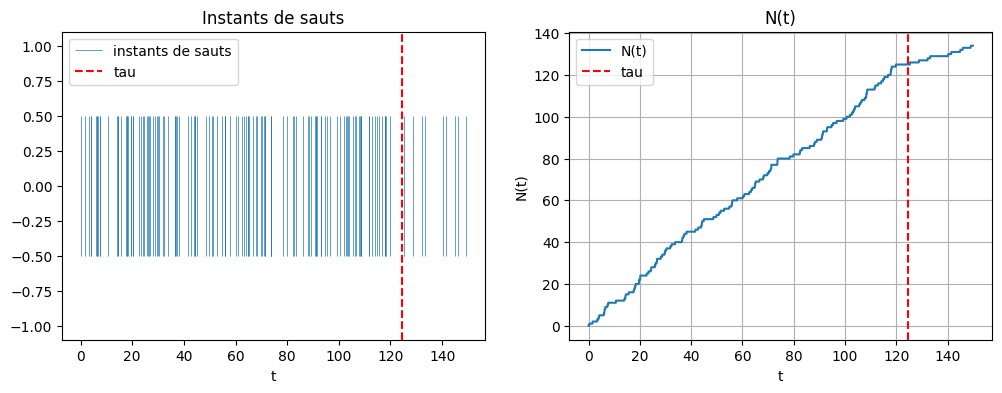

In [ ]:
# test

# définition des paramètres pour le test
a_test = 1
b_test = 1/8
sigma_test = 1/50

# simulation d'une trajectoire
sauts_l, tau = sauts(a_test, b_test, sigma_test, 150)

print("Valeur de tau pour cette trajectoire : " + str(tau))
print("Valeur de a : " + str(a_test))
print("Valeur de b : " + str(b_test))
print("Valeur de sigma " + str(sigma_test))

# plot de la trajectoire
plot_traj(sauts_l, tau, 150)

In [ ]:
def Z(sauts_l, tn, a, b, z0=0):
  """
  Fonction qui résout l'équation différentielle vérifiée par l'estimateur de Z.
  La résolution se fait à l'aide d'une méthode d'Euler.

  arguments :
    sauts_l (List[float]) : liste des instants de sauts du processus N
    tn (List[float]) : liste d'instants considérés pour la résolution de l'ED
    a (float) : intensité du premier processus (N_a)
    b (float) : intensité du second processus (N_b)
    z0 (float) : valeur de z à t = 0. Par defaut z0 = 0

  retours :
    z_l (List[float]) : liste d'approximations des valeurs de z(t) pour t dans tn
  """

  z_l = [z0]
  n = len(tn)
  id_saut = 0

  for i in range(1, n):
    z_tmp = z_l[-1]

    # On distingue les cas ou l'on rencontre un saut de N ou non
    if id_saut < len(sauts_l) and tn[i] >= sauts_l[id_saut]:
      id_saut += 1
      z_l.append(z_tmp + ((b - a) * z_tmp * (1 - z_tmp)) / (a + (b - a) * z_tmp))
    else:
      z_l.append(z_tmp + (tn[i] - tn[i - 1]) * ((1 - z_tmp) * (sigma - (b - a) * z_tmp)))
  return z_l

In [ ]:
# définition des paramètres pour la simulation
a = 4
b = 8
sigma = 1/25
t_max = 100

Valeur de tau : 25.95410538076492


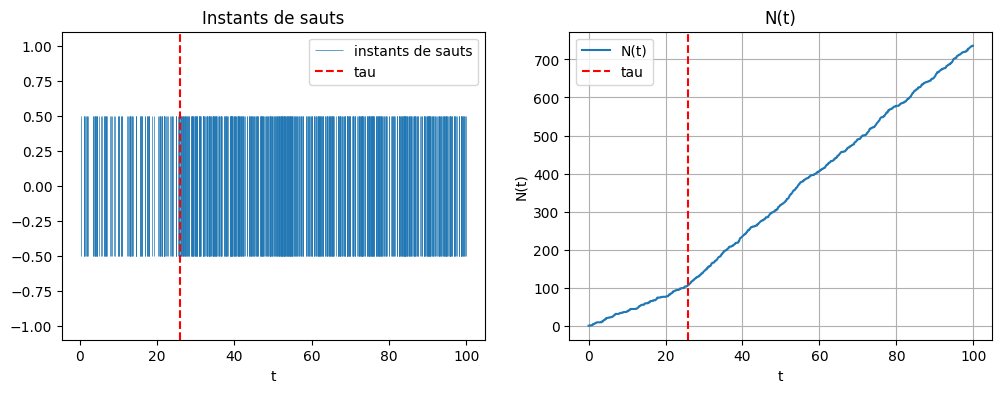

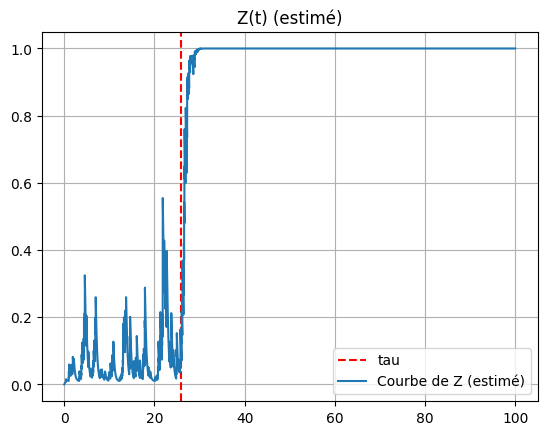

In [ ]:
# simulation et affichage d'une trajectoire
sauts_l, tau = sauts(a, b, sigma, t_max)
print("Valeur de tau : " + str(tau))
plot_traj(sauts_l, tau, t_max)

# simulation puis affichage de Z (estimé) correspondant
tn = np.linspace(0, t_max, t_max * 10**4)
z_l = Z(sauts_l, tn, a, b)

# affichage
plt.axvline(x=tau, linestyle = "--", color = 'red', label = "tau")
plt.plot(tn, z_l, label = "Courbe de Z (estimé)")
plt.title("Z(t) (estimé)")
plt.grid()
plt.legend()
plt.show()

### Estimation de tau

Considérons l'observation réelle $Z(t)$. Alors $\tau$ vérifie :
$\left\{\begin{matrix}
  \forall t > \tau,~ Z(t) = 1
 \\
  \forall t < \tau,~ Z(t) = 0
\end{matrix}\right.
$

On remarque en particulier que pour tout $C \in ]0, 1[$ on a : $\tau = inf\{t>0, Z(t) > C\}$

En observant $\hat Z$, on remarque que l'on a intérêt à choisir une grande valeur de $C$ afin d'éviter l'influence du bruit sur la détection. Le choix d'une grande valeur de C induit cependant un retard dans la détection de $\tau$.

In [ ]:
def tau_estim(z_l, tn, palier):
  """
  fonction qui permet d'estimer la valeur de tau étant donnée une courbe de z (estimé)

  arguments :
    z_l (Liste[float]) : liste des valeurs de z
    tn (Liste[float]) : liste des valeurs de temps auquels on connait z
    palier (float) : valeur à partir de laquelle on considère qu'on a dépassé tau.

  retours :
    _ (float) : tau (estimé à partir de la courbe de z)
  """

  i = 0
  while (i < len(z_l) - 1) and z_l[i] < palier:
    i += 1
  return tn[i]

In [ ]:
# exemple pour une valeur de C donnée
print("Valeur estimée : " + str(tau_estim(z_l, tn, 0.75)))
print("Valeur réelle : "+ str(tau))

Valeur estimée : 26.683426683426685
Valeur réelle : 25.95410538076492


In [ ]:
# on fait le test plusieurs fois pour obtenir la distribution de tau_estimé - tau

n_test = 100
test_l = []
C = 0.75

for i in range(0, n_test):
  tn = np.linspace(0, t_max, t_max * 10**3)
  sauts_l, tau = sauts(a, b, sigma, t_max)
  z_l = Z(sauts_l, tn, a, b)
  val_tau_estim = tau_estim(z_l, tn, C)
  test_l.append(val_tau_estim - tau)

Moyenne de tau (estimé) - tau (pour C = 0.75) : -3.7758088028648142
Moyenne de tau (estimé) - tau | (tau(estimé) - tau > 0) (pour C = 0.75) : 2.065451085334859


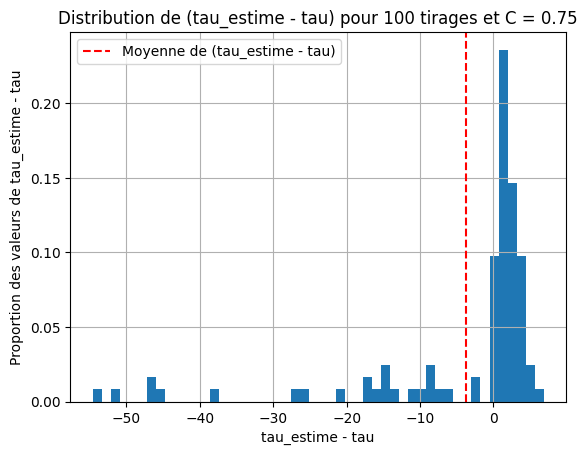

In [ ]:
# affichage
print("Moyenne de tau (estimé) - tau (pour C = " + str(C) + ") : " + str(np.mean(test_l)))
moy_cond = n_test/sum([1 if test >= 0 else 0 for test in test_l])*np.mean([test if test >= 0 else 0 for test in test_l])
print("Moyenne de tau (estimé) - tau | (tau(estimé) - tau > 0) (pour C = " + str(C) + ") : " + str(moy_cond))
n, bins, patches = plt.hist(test_l, n_test // 2, density = True)
plt.axvline(x=np.mean(test_l), linestyle = "--", color = 'red', label = "Moyenne de (tau_estime - tau)")
plt.title("Distribution de (tau_estime - tau) pour " + str(n_test) + " tirages et C = " + str(C))
plt.xlabel("tau_estime - tau")
plt.ylabel("Proportion des valeurs de tau_estime - tau")
plt.grid()
plt.legend()
plt.show()

In [ ]:
# on fait le test plusieur fois pour obtenir la distribution de tau_estime - tau, avec une autre valeur de C
n_test = 100
test_l = []
C = 0.99

for i in range(0, n_test):
  tn = np.linspace(0, t_max, t_max * 10**3)
  sauts_l, tau = sauts(a, b, sigma, t_max)
  z_l = Z(sauts_l, tn, a, b)
  val_tau_estim = tau_estim(z_l, tn, C)
  test_l.append(val_tau_estim - tau)

Moyenne de tau (estimé) - tau (pour C = 0.99) : 2.6047087584522366
Moyenne de tau (estimé) - tau | (tau(estimé) - tau > 0) (pour C = 0.99) : 4.049486456616709


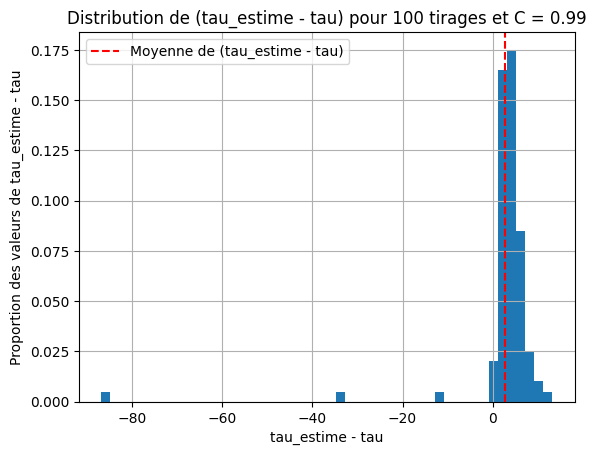

In [ ]:
# affichage
print("Moyenne de tau (estimé) - tau (pour C = " + str(C) + ") : " + str(np.mean(test_l)))
moy_cond = n_test/sum([1 if test >= 0 else 0 for test in test_l])*np.mean([test if test >= 0 else 0 for test in test_l])
print("Moyenne de tau (estimé) - tau | (tau(estimé) - tau > 0) (pour C = " + str(C) + ") : " + str(moy_cond))
n, bins, patches = plt.hist(test_l, n_test // 2, density = True)
plt.axvline(x=np.mean(test_l), linestyle = "--", color = 'red', label = "Moyenne de (tau_estime - tau)")
plt.title("Distribution de (tau_estime - tau) pour " + str(n_test) + " tirages et C = " + str(C))
plt.xlabel("tau_estime - tau")
plt.ylabel("Proportion des valeurs de tau_estime - tau")
plt.grid()
plt.legend()
plt.show()

Au regard de ces tests, on constate l'influence du paramètre $C$ sur la détection de $\tau$.

Considérons $E(\hat{\tau} - \tau | \hat{\tau} - \tau > 0)$, que l'on peut comprendre comme $E(\hat{\tau} - \tau | \text{"on a bien dépassé } \tau \text{"})$.

On observe alors l'apparition d'un compromis. En effet, plus $C$ est proche de $1$, plus on aura de retard sur la détection de $\tau$ (sachant que l'on a bien dépassé $\tau$). Cependant on aura alors moins de faux-positifs de détection causés par le bruit.

Au contraire si l'on prend une valeur de $C$ plus faible, on sera plus sensible au bruit (plus de détections aberrantes), mais le retard sur la détection de $\tau$ sachant que l'on a bien dépassé $\tau$ est plus faible, on est plus "réactif".

On peut vérifier cela en faisant un grand nombre de test comme plus haut.

Pour $C = 0.75$, on obtient $E(\hat{\tau} - \tau | \hat{\tau} - \tau > 0) \approx 2$.

Pour $C = 0.99$, on obtient $E(\hat{\tau} - \tau | \hat{\tau} - \tau > 0) \approx 4$.

On observe plus de "faux positifs" (càd de cas ou $\hat{\tau} - \tau < 0$) avec $C = 0.75$ qu'avec $C = 0.99$   

### Question 4

#### Estimateur de Z

On ne fait plus d'hypothèses sur la loi de $\tau$

On peut observer le nombre de sauts entre l'instant $t - T$ et l'instant $t$.
On sait que $N(t - T) - N(t)$ suit une loi de poisson de parametre $\lambda T$. On peut utiliser cette propriété pour déduire si on observe $N_a$ ou $N_b$.

Pour faciliter les calculs, on suppose que $a < b$ (le cas $a > b$ se traite d'une manière similaire).

On cherche un ensemble A tel que :
- Si $N(t) - N(t - T) \in A$, alors on considère qu'on observe $N_a$
- Sinon, on considère qu'on observe $N_b$

Pour obtenir un estimateur de $Z(t)$ $F_t$-mesurable, on choisit :

$\hat{Z}(t) = \frac{1}{P(N_b(t) - N_b(t-T) \notin A) - P(N_a(t) - N_a(t-T) \notin A)} 1_{(N(t) - N(t - T)) \notin A} - \frac{P(N_a(t) - N_a(t-T) \notin A)}{P(N_b(t) - N_b(t-T) \notin A) - P(N_a(t) - N_a(t-T) \notin A)}$

De cette maniere,

Si $t < \tau, E(\hat{Z}(t)) = 0$

Si $t + T > \tau, E(\hat{Z}(t)) = 1$   

On peut ensuite estimer $\tau$ d'une manière proche de la précédente, en considèrant le premier instant auquel $\hat{Z}$ dépasse un palier, ce qui correspond simplement à regarder le premier instant auquel $\hat{Z}(t) >0$ car Z ne prend que deux valeurs.

#### Observation des distributions de $N_a(t) - N_a(t - T)$ et de $N_b(t) - N_b(t - T)$

On peut d'abord observer les distributions de $N_a(t) - N_a(t - T)$ et de $N_b(t) - N_b(t - T)$ pour déterminer la forme que l'on va donner à l'ensemble A.

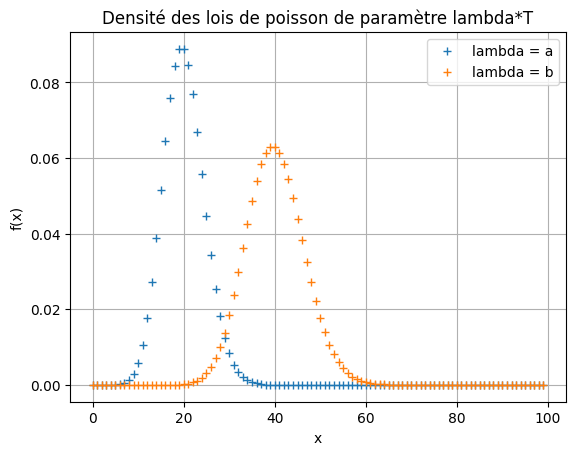

In [ ]:
def plot_distrib(a, b, T, n_max = 500):
  """
  fonction qui affiche les distributions de poisson de parametre aT et bT.

  arguments :
    a (float) : a
    b (float) : b
    T (float) : T
    n_max (int) : nombre de points considérés

  retours : aucun

  """
  distrib_a = [(math.exp( - a * T) * (a * T) ** i)/math.factorial(i) for i in range(0, n_max//T)]
  distrib_b = [(math.exp( - b * T) * (b * T) ** i)/math.factorial(i) for i in range(0, n_max//T)]
  t_l = [i for i in range(0, n_max//T)]
  plt.plot(t_l, distrib_a, "+", label = "lambda = a")
  plt.plot(t_l, distrib_b, "+", label = "lambda = b")

  plt.title("Densité des lois de poisson de paramètre lambda*T")
  plt.xlabel("x")
  plt.ylabel("f(x)")
  plt.grid()
  plt.legend()
  plt.show()

plot_distrib(4, 8, 5)



En observant les distributions, on peut déduire qu'il est judicieux de chercher A de la forme $[0, k_T]$.

On a de l'influence sur deux paramètres : $T$ et $k_T$

A $T$ fixé, il s'agit d'avoir une valeur de $P(N_{\lambda}(t) - N_{\lambda}(t - T) \in [0, k_T] |\lambda = a)$ proche de $1$ tout en ayant une valeur de $P(N_{\lambda}(t - T) - N_{\lambda}(t) \in [0, k_T] |\lambda = b)$ proche de $0$.

On fixe un $\alpha$ donné dans $]0, 1[$ et on cherche $k_T$ tel que $P(N_{\lambda}(t) - N_{\lambda}(t - T) \in [0, k_T] |\lambda = a) > 1 - \alpha$. On choisit donc $k_T$ tel que $k_T = \text{argmin}_{k \in N} \{P(N_{\lambda}(t) - N_{\lambda}(t - T) \in [0, k] |\lambda = a) > 1 - \alpha\}$ (qui existe et unique car $P(N_{\lambda}(t) - N_{\lambda}(t - T) \in [0, k] |\lambda = a)$ est une fonction croissante de $k$)

#### Choix de T

Il reste à choisir T de manière à obtenir une valeur de $P(N_{\lambda}(t) - N_{\lambda}(t-T) \in [0, k_T] |\lambda = b)$ proche de $0$, ou de manière équivalente $P(N_{\lambda}(t) - N_{\lambda}(t-T) > k_T |\lambda = b)$ proche de 1.

Il s'agit ici d'obtenir une prédiction assez bonne ($P(N_{\lambda}(t) - N_{\lambda}(t-T) > k_T |\lambda = b)$ proche de 1) tout en gardant $T$ petit, car $\hat{Z}$ n'estime pas bien $Z$ sur $[\tau, \tau + T]$, diminuer $T$ permet de limiter la zone "d'incertitude".

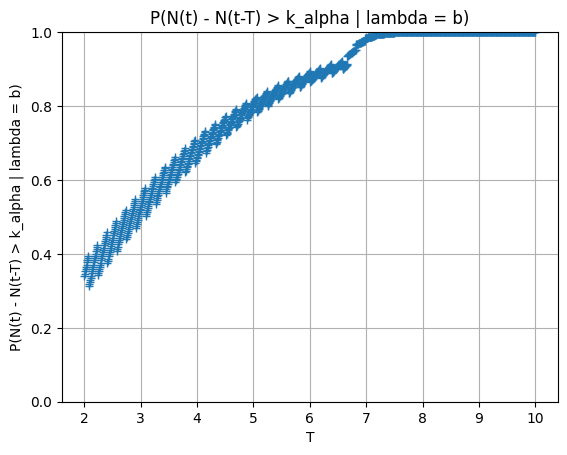

In [ ]:
def plot_prob(a, b, alpha, T_l, n_max = 300):
  """
  fonction qui affiche P(N(t) - N(t-T) > k_alpha | lambda = b) en fonction de T.

  arguments :
    a (float) : a
    b (float) : b
    T_l (List(float)) : liste des T qu'on considère dans l'affichage
    n_max (int) : nombre de points considérés...

  retours : aucun

  """
  y = []
  for T in T_l:
    distrib_a = [(math.exp( - a * T) * (a * T) ** i)/math.factorial(i) for i in range(0, int(n_max/T))]
    distrib_b = [(math.exp( - b * T) * (b * T) ** i)/math.factorial(i) for i in range(0, int(n_max/T))]
    j = 0
    while j in range(0, int(n_max/T)) and sum(distrib_a[:j]) < 1 - alpha:
      j += 1
    y.append(1 - sum(distrib_b[:(j-1)]))
  plt.title("P(N(t) - N(t-T) > k_alpha | lambda = b)")

  plt.plot(T_l, y, "+")

  plt.ylabel("P(N(t) - N(t-T) > k_alpha | lambda = b)")
  plt.xlabel("T")
  plt.ylim([0,1])
  plt.grid()
  plt.show()

plot_prob(a, b, 0.001, np.linspace(2, 10, 10**3))

On peut prendre $T = inf_T \{ P(N(t) - N(t-T) > k_T |\lambda = b) > 1 - \beta\}$, avec $\beta$ fixé dans $]0,1[$. On a intérêt à prendre $\beta << 1$ .

In [ ]:
# définition des paramètres pour la simulation
a = 4
b = 8
sigma = 1/30
t_max = 100

n_max = 100

alpha = 0.001
beta = 0.01

In [ ]:
def trouver_T_K(a, b, alpha, beta, T_l, n_max = 100):
  """
  fonction qui permet de trouver les paramètres T et K_T évoqués plus haut.

  arguments :
    a (float) : a
    b (float) : b
    alpha (float) :
    beta (float) :
    n_max (int) :

  retours :
    T (float) :
    j (int) :

  """

  for T in T_l:
    distrib_a = [(math.exp( - a * T) * (a * T) ** i)/math.factorial(i) for i in range(0, n_max)]
    distrib_b = [(math.exp( - b * T) * (b * T) ** i)/math.factorial(i) for i in range(0, n_max)]
    j = 0
    while j in range(0, n_max) and sum(distrib_a[:j]) < 1 - alpha:
      j += 1
    # ce j correspond à K_T
    if sum(distrib_b[:j]) < beta and sum(distrib_a[:j]) >= 1 - alpha:
      return T, j

  return -1, -1 # correspond a une erreur

valeur de T : 10.516516516516516
valeur de K : 64


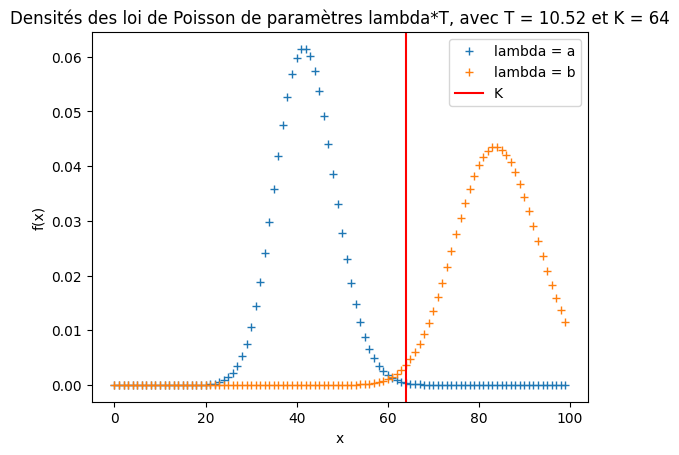

In [ ]:
T, K = trouver_T_K(a, b, alpha, beta, np.linspace(2, 14, 10**3))

print("valeur de T : " + str(T))
print("valeur de K : " + str(K))

distrib_a = [(math.exp( - a * T) * (a * T) ** i)/math.factorial(i) for i in range(0, n_max)]
distrib_b = [(math.exp( - b * T) * (b * T) ** i)/math.factorial(i) for i in range(0, n_max)]
t_l = [i for i in range(0, n_max)]
plt.plot(t_l, distrib_a, "+", label = "lambda = a")
plt.plot(t_l, distrib_b, "+", label = "lambda = b")
plt.title("Densités des loi de Poisson de paramètres lambda*T, avec T = " + str(round(T, 2)) + " et K = " + str(K))
plt.xlabel("x")
plt.ylabel("f(x)")
plt.axvline(x=K, color = 'red', label = "K")
plt.legend()
plt.show()

In [ ]:
def z_estim(sauts_l, tn):
  """
  fonction qui estime z comme expliqué précédement

  arguments :
    sauts_l (list[float]) : liste des sauts du processus N observé
    tn (list[float]) : liste des instants considérés

  retour :
    _ (list[float]) : liste correspondant aux valeurs de z_estim sur les points de tn
  """
  Pa = sum([(math.exp( - a * T) * (a * T) ** i)/math.factorial(i) for i in range(0, int(300/T))][:K])
  Pb = sum([(math.exp( - b * T) * (b * T) ** i)/math.factorial(i) for i in range(0, int(300/T))][:K])
  print(Pa)
  print(Pb)
  n = len(tn)
  s_l = np.zeros(n)
  z_l = []
  for i in range(0, n):
    for saut in sauts_l:
      if saut < tn[i] and saut > tn[i] - T:
        s_l[i] += 1
    if s_l[i] > K:
      z_l.append((1 - Pa) / (1 - Pb - Pa))
    else:
      z_l.append((- Pa) / (1 - Pb - Pa))
  return z_l

Valeur de tau : 15.76322680667227


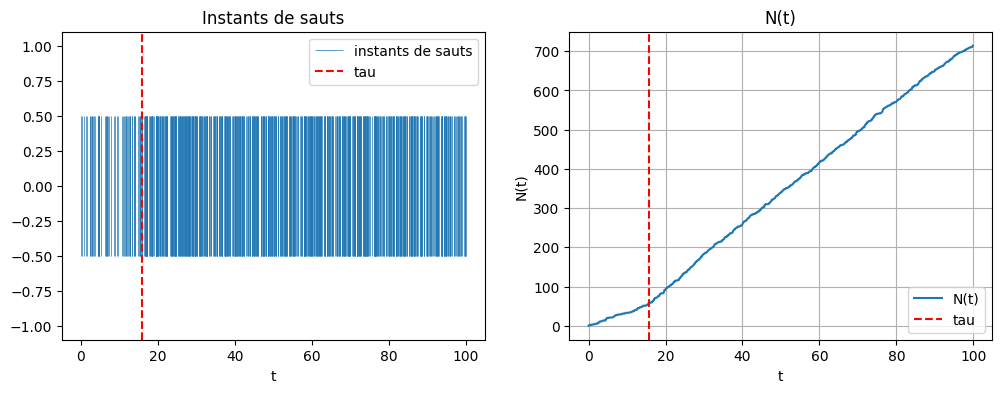

0.00886566408648556
3.6604958937084723e-13


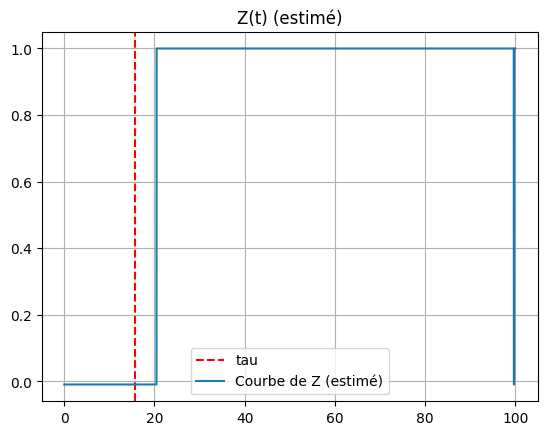

In [ ]:
# simulation et affichage d'une trajectoire
sauts_l, tau = sauts(a, b, sigma, t_max)
print("Valeur de tau : " + str(tau))
plot_traj(sauts_l, tau, t_max)

# simulation puis affichage de Z (estimé) correspondant
tn = np.linspace(0, t_max, t_max * 10**4)
z_l = Z(sauts_l, tn, a, b)

# affichage
plt.axvline(x=tau, linestyle = "--", color = 'red', label = "tau")
plt.plot(np.linspace(0, t_max, t_max * 10**2), z_estim(sauts_l, np.linspace(0, t_max, t_max * 10**2)), label = "Courbe de Z (estimé)")
plt.title("Z(t) (estimé)")
plt.grid()
plt.legend()
plt.show()

#### Estimation de tau

On peut ensuite estimer $\tau$ de la manière suivante :

$\hat{\tau} = \text{inf}\{t > 0, N(t) - N(t - T) > k_T\}$

On a par ailleurs $\hat{\tau} = \text{inf}\{t > 0, \hat{Z}(t) > C\}$ pour $C$ dans $]0,1[$


In [ ]:
def tau_estim_2(sauts_l, tn):
  """
  fonction qui estime tau comme expliqué précédement

  arguments :
    sauts_l (list[float]) : liste des sauts du processus N observé
    tn (list[float]) : liste des instants considérés

  retour :
    _ (float) : tau estimé
  """

  n = len(tn)
  s_l = np.zeros(n)
  for i in range(0, n):
    for saut in sauts_l:
      if saut < tn[i] and saut > tn[i] - T:
        s_l[i] += 1
    if s_l[i] > K:
      return tn[i]
  return tn[i]

In [ ]:
# test pour tirage donné
tn = np.linspace(0, t_max, t_max * 10**4)
sauts_l, tau = sauts(a, b, sigma, t_max)
print("valeur de tau : " + str(tau))
print("valeur de tau estimée : " + str(tau_estim_2(sauts_l, np.linspace(0, t_max, t_max * 10**2))))

valeur de tau : 51.3019677132505
valeur de tau estimée : 52.21522152215222


In [ ]:
n_test = 200
test_l = []
for i in range(0, n_test):
  sauts_l, tau = sauts(a, b, sigma, t_max)
  val_tau_estim = tau_estim_2(sauts_l, np.linspace(0, t_max, t_max * 10))
  test_l.append(val_tau_estim - tau)

alpha : 0.001
beta : 0.01
K : 64
T : 10.516516516516516
Moyenne de tau (estimé) - tau : 3.8638147662816924
Moyenne de tau (estimé) - tau | (tau(estimé) - tau > 0) : 5.663983247176362


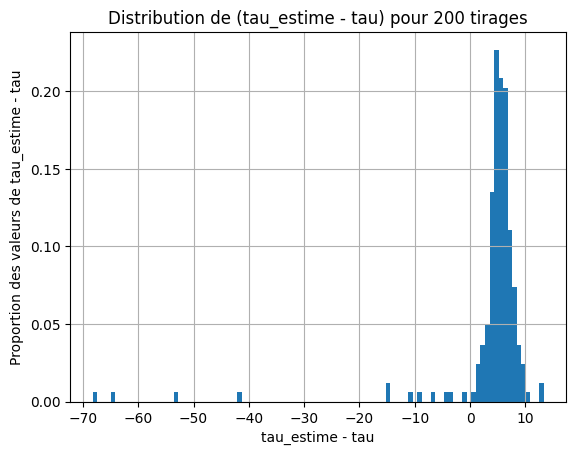

In [ ]:
print("alpha : " + str(alpha))
print("beta : " + str(beta))
print("K : " + str(K))
print("T : " + str(T))

print("Moyenne de tau (estimé) - tau : " + str(np.mean(test_l)))
moy_cond = n_test/sum([1 if test >= 0 else 0 for test in test_l])*np.mean([test if test >= 0 else 0 for test in test_l])
print("Moyenne de tau (estimé) - tau | (tau(estimé) - tau > 0) : " + str(moy_cond))
n, bins, patches = plt.hist(test_l, n_test // 2, density = True)
plt.title("Distribution de (tau_estime - tau) pour " + str(n_test) + " tirages")
plt.xlabel("tau_estime - tau")
plt.ylabel("Proportion des valeurs de tau_estime - tau")
plt.grid()
plt.show()

In [ ]:
# d'autres test avec d'autres valeurs de alpha et beta

alpha = 0.05
beta = 0.05

T, K = trouver_T_K(a, b, alpha, beta, np.linspace(2, 14, 10**3))

n_test = 200
test_l = []
for i in range(0, n_test):
  sauts_l, tau = sauts(a, b, sigma, t_max)
  val_tau_estim = tau_estim_2(sauts_l, np.linspace(0, t_max, t_max * 10))
  test_l.append(val_tau_estim - tau)

alpha : 0.05
beta : 0.05
K : 24
T : 4.078078078078078
Moyenne de tau (estimé) - tau (pour C = 0.99) : -9.588664757904816
Moyenne de tau (estimé) - tau | (tau(estimé) - tau > 0) (pour C = 0.99) : 2.2490261030802743


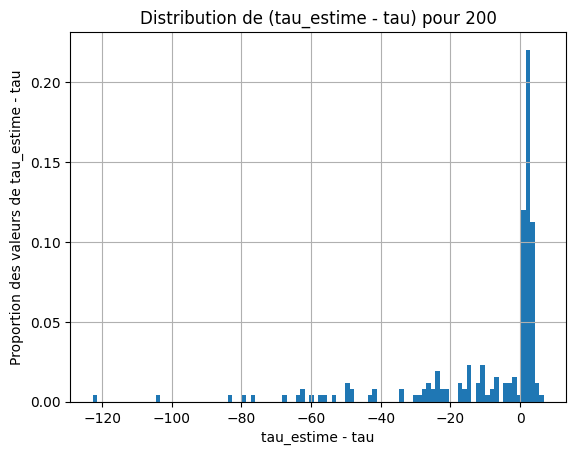

In [ ]:
print("alpha : " + str(alpha))
print("beta : " + str(beta))
print("K : " + str(K))
print("T : " + str(T))

print("Moyenne de tau (estimé) - tau (pour C = " + str(C) + ") : " + str(np.mean(test_l)))
moy_cond = n_test/sum([1 if test >= 0 else 0 for test in test_l])*np.mean([test if test >= 0 else 0 for test in test_l])
print("Moyenne de tau (estimé) - tau | (tau(estimé) - tau > 0) (pour C = " + str(C) + ") : " + str(moy_cond))
n, bins, patches = plt.hist(test_l, n_test // 2, density = True)
plt.title("Distribution de (tau_estime - tau) pour " + str(n_test))
plt.xlabel("tau_estime - tau")
plt.ylabel("Proportion des valeurs de tau_estime - tau")
plt.grid()
plt.show()

#### Influence de $\alpha$ et $\beta$

Tout comme avec l'estimateur précédent, prendre des valeurs de $\alpha$ et $\beta$ proche de 0 va permettre de faire peut d'erreurs dans lorsqu'on estime qu'on a dépassé $\tau$, mais cela va induire un retard.

Au contraire, lorsqu'on prend $\alpha$ et $\beta$ plus grands, la réactivité est meilleure, mais on estime plus facilement qu'on a dépassé $\tau$ sans que cela soit le cas.

Pour $\alpha = 0.001$ et $\beta = 0.01$, on obtient $E(\hat{\tau} - \tau | \hat{\tau} - \tau > 0) \approx 6$.

Pour $\alpha = 0.05$ et $\beta = 0.05$, on obtient $E(\hat{\tau} - \tau | \hat{\tau} - \tau > 0) \approx 2$.